# Librerias

In [1]:
!pip install tensorflow==2.2.0

     |████████████████████████████████| 516.2MB 32kB/s 
     |████████████████████████████████| 3.0MB 42.0MB/s 
     |████████████████████████████████| 460kB 54.1MB/s 
  Found existing installation: tensorboard 2.4.1
    Uninstalling tensorboard-2.4.1:
      Successfully uninstalled tensorboard-2.4.1
  Found existing installation: tensorflow-estimator 2.4.0
    Uninstalling tensorflow-estimator-2.4.0:
      Successfully uninstalled tensorflow-estimator-2.4.0
  Found existing installation: tensorflow 2.4.1
    Uninstalling tensorflow-2.4.1:
      Successfully uninstalled tensorflow-2.4.1


In [2]:
!pip install tensorflow-probability==0.10.0

     |████████████████████████████████| 3.5MB 7.6MB/s 
  Found existing installation: tensorflow-probability 0.12.1
    Uninstalling tensorflow-probability-0.12.1:
      Successfully uninstalled tensorflow-probability-0.12.1


In [3]:
! pip install -U segmentation-models

     |████████████████████████████████| 51kB 7.4MB/s 


In [4]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [5]:
# Import, authenticate and initialize the Earth Engine library.
import ee
ee.Authenticate()
ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://accounts.google.com/o/oauth2/auth?client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code&code_challenge=2pb2yESxW_igTUp9jZ3FWmrzvDRd6QVq7v32-VEPSW4&code_challenge_method=S256

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/1AY0e-g5dSqdKmzzWrGNnNB4KCqGBbgtnWcqp-lSaXAguV8PjJxSNtSvl_7Q

Successfully saved authorization token.


In [6]:
# Tensorflow setup.
import tensorflow as tf
import tensorflow_probability as tfp
device_name = tf.test.gpu_device_name()
tf.executing_eagerly()
print(tf.__version__)
print(device_name)

2.2.0
/device:GPU:0


In [7]:
%env SM_FRAMEWORK=tf.keras
import segmentation_models as sm

env: SM_FRAMEWORK=tf.keras
Segmentation Models: using `tf.keras` framework.


In [8]:
import matplotlib.pyplot as plt 
import numpy as np
import glob
import os
from os.path import join

# Configuraciones

In [9]:
# NOMBRE DEL PROYECTO
PROYECTO = 'Mineria2_Planet'
BUCKET = 'mineriapr'

# BANDAS Y VARIABLE RESPUESTA
opticalBands = ['R', 'G', 'B', 'NIR','R2', 'G2', 'B2', 'NIR2']
#opticalBands = ['R', 'G', 'B']
BANDS = opticalBands
RESPONSE = 'landcover'
FEATURES = BANDS + [RESPONSE]

# ESPECIFICACIONES DE LOS DATOS DE ENTRADA DEL MODELO DE SEGMENTACIÓN
KERNEL_SIZE = 256
KERNEL_SHAPE = [KERNEL_SIZE, KERNEL_SIZE]
COLUMNS = [
  tf.io.FixedLenFeature(shape=KERNEL_SHAPE, dtype=tf.float32) for k in FEATURES
]
FEATURES_DICT = dict(zip(FEATURES, COLUMNS))

# ESPECIFICACIONES DE LOS DATOS DE ENTRENAMIENTO DEL MODELO
BATCH_SIZE = 16
BUFFER_SIZE = 200

In [10]:
BUCKET = 'mineriapr'
!gcloud auth login
!gcloud auth application-default login
#!gcloud auth application-default login
project_id = 'landai-270016'
!gcloud config set project {project_id}
!gsutil ls
!gsutil ls 'gs://mineriapr/'

Go to the following link in your browser:

    https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcloud-platform+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fappengine.admin+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcompute+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Faccounts.reauth&state=XuwGgdc64TTy1K3l1h9ubNgEtWEnKZ&prompt=consent&access_type=offline&code_challenge=nxtc_BUspFHUMBPB2Kw6q_-n5l2eP3mnrlzaEMs31hA&code_challenge_method=S256

Enter verification code: 4/1AY0e-g4BnQMnSjd7AUl-7InqBS62nn-dEMXWaquPT2mng3RTwL_XCyvU2PY

You are now logged in as [mazarazaa@correo.udistrital.edu.co].
Your current project is [None].  You can change this setting by running:
  $ gcloud config set project PROJECT_ID
Go to the following link in your browser:

    https://accounts.google.com/o

## Funciones preparación de los datos

In [11]:
def aug_color(img):
    n_ch = tf.shape(img)[-1]
    contra_adj = 0.05
    bright_adj = 0.05

    ch_mean = tf.math.reduce_mean(img, axis = (0,1), keepdims = True)
    #ch_mean = np.mean(img, axis=(0, 1), keepdims=True).astype(np.float32)

    contra_mul = tf.random.uniform(shape = (1, 1, n_ch),
                                   minval = 1-contra_adj,
                                   maxval = 1+contra_adj)
    # contra_mul = np.random.uniform(1 - contra_adj, 1 + contra_adj, (1, 1, n_ch)).astype(
    #     np.float32
    # )

    bright_mul = tf.random.uniform(shape = (1, 1, n_ch),
                                   minval = 1 - bright_adj,
                                   maxval = 1+bright_adj)
    # bright_mul = np.random.uniform(1 - bright_adj, 1 + bright_adj, (1, 1, n_ch)).astype(
    #     np.float32
    # )

    recolored = (img - ch_mean) * contra_mul + ch_mean * bright_mul
    return recolored
  
def normalize(x, axes=[0, 1, 2], epsilon=1e-8):
  """
  Standardize incoming image patches by local mean and variance
  Parameters:
    x (tensor): nD image tensor
    axes (array): Array of ints. Axes along which to compute mean and variance, usually length n-1
    epsilon (float): small number to avoid dividing by zero
  Return:
    tensor: nD image tensor normalized by channels
  """
  mean, variance = tf.nn.moments(x, axes=axes)
  x_normed = (x - mean) / tf.sqrt(variance + epsilon) # epsilon to avoid dividing by zero
  return x_normed

def standard(img, axes = [0, 1, 2]):
  # shape attribute returns a tuple (256, 256, 6)
  dims = tf.shape(img)
  H = dims[0]
  W = dims[1]
  C = dims[2]
  ninetyninth = tfp.stats.percentile(img, 99, axis = axes, interpolation = 'lower')
  # create a list of HxW tensors holding 99th percentile values per band
  maximum = tf.reshape(tf.repeat(ninetyninth, repeats = [H*W, H*W, H*W, H*W, H*W, H*W]), [H,W,C]) 
  minimum = tf.reshape(tf.repeat([0.0], repeats = [H*W*C]), shape = (H, W, C))
  #maximum = tf.reshape(tf.repeat([100.0], repeats = [H*W*C]), shape = (H, W, C))
  clipped = tf.clip_by_value(img, clip_value_min = minimum, clip_value_max = maximum)
  scaled = tf.divide(tf.subtract(clipped, minimum), tf.subtract(maximum, minimum))
  return scaled

def aug_img(img):
  """
  Perform morphometric augmentation of input image
  Parameters:
    img (3D array):
  Returns:
    3D image array:
  """
  outDims = tf.shape(img)[0:1]
  x = tf.image.random_flip_left_right(img)
  x = tf.image.random_flip_up_down(x)
  x = rotated = tf.image.rot90(x, tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))
  #since were gonna map_fn this on a 4d image, output must be 3d, so squeeze the artificial 'sample' dimension
  return tf.squeeze(x)

def preprocess(img, labels):
  dims = tf.shape(img)
  #need to combine labels and bands for morphological transformations
  comb = tf.concat([img, tf.expand_dims(labels, axis = 2)], axis = 2)
  aug = aug_img(comb)
  #aug = tf.map_fn(fn = aug_img, elems = comb)
  labels = tf.squeeze(aug[:, :, -1])
  band_stack = color(aug[:, :, 0:dims[2]])
  return band_stack, labels

## Funciones lectura de los datos

In [12]:
def parse_tfrecord(example_proto):
  """The parsing function.
  Read a serialized example into the structure defined by FEATURES_DICT.
  Args:
    example_proto: a serialized Example.
  Returns: 
    A dictionary of tensors, keyed by feature name.
  """
  return tf.io.parse_single_example(example_proto, FEATURES_DICT)

def to_tuple(inputs):
  """Function to convert a dictionary of tensors to a tuple of (inputs, outputs).
  Turn the tensors returned by parse_tfrecord into a stack in HWC shape.
  Args:
    inputs: A dictionary of tensors, keyed by feature name.
  Returns: 
    A dtuple of (inputs, outputs).
  """
  inputsList = [inputs.get(key) for key in FEATURES]
  stacked = tf.stack(inputsList, axis=0)
  # Convert from CHW to HWC
  stacked = tf.transpose(stacked, [1, 2, 0])
  # Perform image augmentation
  stacked = aug_img(stacked)
  # split input bands and labels
  bands = stacked[:,:,:len(BANDS)]
  labels = stacked[:,:,len(BANDS):]
  # do color augmentation on input features
  bands = aug_color(bands)
  # standardize each patch of bands
  bands = normalize(bands, [0, 1])
  return bands, labels 

def get_dataset(pattern):
  """Function to read, parse and format to tuple a set of input tfrecord files.
  Get all the files matching the pattern, parse and convert to tuple.
  Args:
    pattern: A file pattern to match in a Cloud Storage bucket.
  Returns: 
    A tf.data.Dataset
  """
  glob = tf.io.gfile.glob(pattern)
  dataset = tf.data.TFRecordDataset(glob, compression_type='GZIP')
  dataset = dataset.map(parse_tfrecord, num_parallel_calls=5)
  dataset = dataset.map(to_tuple, num_parallel_calls=5)
  return dataset

def get_training_dataset(pattern):
	"""Get the preprocessed training dataset
	Parameters:
		pattern (str): directory path to training data
  Returns: 
    A tf.data.Dataset of training data.
  """
	dataset = get_dataset(pattern)
	dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
	return dataset

def get_val_eval_dataset(pattern):
	"""
	Get the preprocessed evaluation dataset
	Parameters:
		pattern (str): directory path to training data
  Returns: 
    A tf.data.Dataset of evaluation data.
  """
	dataset = get_dataset(pattern)
	dataset = dataset.batch(1).repeat()
	return dataset

## Otras funciones

In [13]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

class PlotLearning(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.iou = []
        self.val_iou = []
        self.f1score = []
        self.val_f1score = []
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.iou.append(logs.get('iou_score'))
        self.val_iou.append(logs.get('val_iou_score'))
        self.f1score.append(logs.get('f1-score'))
        self.val_f1score.append(logs.get('val_f1-score'))
        self.i += 1
        f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex=True, figsize=(15,5))
        
        clear_output(wait=True)
        
        ax1.set_yscale('log')
        ax1.plot(self.x, self.losses, label="loss")
        ax1.plot(self.x, self.val_losses, label="val_loss")
        ax1.legend()
        
        ax2.plot(self.x, self.iou, label="iou")
        ax2.plot(self.x, self.val_iou, label="val_iou")
        ax2.legend()

        ax3.plot(self.x, self.f1score, label="f1score")
        ax3.plot(self.x, self.val_f1score, label="val_f1score")
        ax3.legend()

        plt.show();
        
plot = PlotLearning()

## Cargar los datos

In [14]:
def cargaDatos(indir, periodo, particion):
  if periodo == 'T1-T2-T3':
    periodo = ''
  particionPattern = join(indir, f'{particion}_' + periodo + '*.tfrecord.gz')
  listParticion = tf.io.gfile.glob(particionPattern)
  print(f'La particion {particion} del periodo {periodo} tiene un total de {len(listParticion)} TFRecords')
  data = get_training_dataset(listParticion)
  return data

In [15]:
periodo = 'T1-T2-T3' #T1-T2 para ambos
n = 5
N = 50

#indir = join('/content/gdrive/My Drive',PROYECTO,'datos',f'n{n}_N{N}')
indir = join('/content/gdrive/My Drive',PROYECTO)

# entrenamiento
training = cargaDatos(indir,periodo,'training')
validation = cargaDatos(indir,periodo,'validation')
evaluation = cargaDatos(indir,periodo,'eval')

La particion training del periodo  tiene un total de 126 TFRecords
La particion validation del periodo  tiene un total de 33 TFRecords
La particion eval del periodo  tiene un total de 12 TFRecords


In [16]:
indir = join('/content/gdrive/My Drive',PROYECTO)
particionPattern = join(indir, 'training_T' + '*.tfrecord.gz')
listParticion = tf.io.gfile.glob(particionPattern)

# Modelado

In [17]:
from tensorflow.python.keras import layers
from tensorflow.python.keras import losses
from tensorflow.python.keras import models
from tensorflow.python.keras import metrics
from tensorflow.python.keras import optimizers
from tensorflow.keras import backend as K
from segmentation_models.base import Loss

In [18]:
##función TverskyLoss
class TverskyLoss(Loss):
    def __init__(self, alpha=0.45, beta=0.55, class_weights=None):
        super().__init__(name='tversky_loss')
        self.alpha = alpha
        self.beta = beta
        self.class_weights = class_weights if class_weights is not None else 1.

    def __call__(self, gt, pr):
        return _tversky_loss(
            gt=gt, 
            pr=pr, 
            alpha=self.alpha, 
            beta=self.beta, 
            class_weights=self.class_weights
        )


class FocalTverskyLoss(Loss):
    def __init__(self, alpha=0.45, beta=0.55, gamma=2.5, class_weights=None):
        super().__init__(name='tversky_loss')
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.class_weights = class_weights if class_weights is not None else 1.

    def __call__(self, gt, pr):
        return _focal_tversky_loss(
            gt=gt, 
            pr=pr, 
            alpha=self.alpha, 
            beta=self.beta, 
            gamma=self.gamma, 
            class_weights=self.class_weights
        )

def _tversky_index(gt, pr, alpha, beta):
    eps = K.epsilon()
    pr = tf.clip_by_value(pr, eps, 1 - eps)
    reduce_axes = [0, 1, 2]
    tp = tf.reduce_sum(gt * pr, axis=reduce_axes)
    fp = tf.reduce_sum(pr, axis=reduce_axes) - tp
    fn = tf.reduce_sum(gt, axis=reduce_axes) - tp
    return (tp + eps) / (tp + alpha*fp + beta*fn + eps)


def _tversky_loss(gt, pr, alpha=0.45, beta=0.55, class_weights=1., **kwargs):
    index = _tversky_index(gt, pr, alpha, beta) * class_weights
    return 1.0 - tf.reduce_mean(index)

def _focal_tversky_loss(gt, pr, alpha=0.45, beta=0.55, gamma=2.5, class_weights=1., **kwargs):
    gamma = tf.clip_by_value(gamma, 1.0, 3.0)
    index =_tversky_index(gt, pr, alpha, beta) * class_weights
    loss = K.pow((1.0 - index), (1.0 / gamma))
    return K.mean(loss)

In [19]:
def conv_block(input_tensor, num_filters):
	encoder = layers.Conv2D(num_filters, (3, 3), padding='same')(input_tensor)
	encoder = layers.BatchNormalization()(encoder)
	encoder = layers.Activation('relu')(encoder)
	encoder = layers.Conv2D(num_filters, (3, 3), padding='same')(encoder)
	encoder = layers.BatchNormalization()(encoder)
	encoder = layers.Activation('relu')(encoder)
	return encoder

def encoder_block(input_tensor, num_filters):
	encoder = conv_block(input_tensor, num_filters)
	encoder_pool = layers.MaxPooling2D((2, 2), strides=(2, 2))(encoder)
	return encoder_pool, encoder

def decoder_block(input_tensor, concat_tensor, num_filters):
	decoder = layers.Conv2DTranspose(num_filters, (2, 2), strides=(2, 2), padding='same')(input_tensor)
	decoder = layers.concatenate([concat_tensor, decoder], axis=-1)
	decoder = layers.BatchNormalization()(decoder)
	decoder = layers.Activation('relu')(decoder)
	decoder = layers.Conv2D(num_filters, (3, 3), padding='same')(decoder)
	decoder = layers.BatchNormalization()(decoder)
	decoder = layers.Activation('relu')(decoder)
	decoder = layers.Conv2D(num_filters, (3, 3), padding='same')(decoder)
	decoder = layers.BatchNormalization()(decoder)
	decoder = layers.Activation('relu')(decoder)
	return decoder

def unet_model():
  inputs = layers.Input(shape=[None, None, len(BANDS)])
  encoder0_pool, encoder0 = encoder_block(inputs, 32)
  encoder1_pool, encoder1 = encoder_block(encoder0_pool, 64)
  encoder2_pool, encoder2 = encoder_block(encoder1_pool, 128)
  encoder3_pool, encoder3 = encoder_block(encoder2_pool, 256)
  encoder4_pool, encoder4 = encoder_block(encoder3_pool, 512)
  center = conv_block(encoder4_pool, 1024)# center
  decoder4 = decoder_block(center, encoder4, 512)
  decoder3 = decoder_block(decoder4, encoder3, 256)
  decoder2 = decoder_block(decoder3, encoder2, 128)
  decoder1 = decoder_block(decoder2, encoder1, 64)
  decoder0 = decoder_block(decoder1, encoder0, 32)
  segmentation = layers.Conv2D(1, (1, 1), activation='sigmoid', name='seg')(decoder0)

  return 	models.Model(inputs=[inputs], outputs=[segmentation])

In [20]:
def _get_model(periodo, modelname, modeltype, costloss, pretrained=True, rgb=True):
  
  if costloss == 'diceloss':
    target_loss = sm.losses.DiceLoss()
  elif costloss == 'focalloss':
    target_loss = sm.losses.BinaryFocalLoss()
  elif costloss == 'dicefocalloss':
    loss1 = sm.losses.DiceLoss()
    loss2 = sm.losses.BinaryFocalLoss()
    target_loss = loss1 + (1 * loss2)
  elif costloss == 'focaltverskyloss':
    target_loss = FocalTverskyLoss()
  elif costloss == 'BCEloss':
    target_loss = sm.losses.BinaryCELoss()
  elif costloss == 'jaccardloss':
    target_loss = sm.losses.JaccardLoss()

  if modelname == 'unet-sm':
    if pretrained and not rgb:
      print(f'El modelo {modeltype} usando el metodo {modelname} va ser entrenado para el periodo {periodo} usando bandas RGB-NIR e iniciado con los pesos de imagenet y función de perdida {costloss}')
      base_model = sm.Unet(backbone_name=modeltype, encoder_weights='imagenet', classes=1, activation='sigmoid')
      inp = layers.Input(shape=(None, None, 8))
      l1 = layers.Conv2D(3, (1, 1))(inp) # map N channels data to 3 channels
      out = base_model(l1)
      model = models.Model(inp, out, name=base_model.name)
    elif pretrained and rgb:
      print(f'El modelo {modeltype} usando el metodo {modelname} va ser entrenado para el periodo {periodo} usando bandas RGB e iniciado con los pesos de imagenet y función de perdida {costloss}')
      model = sm.Unet(backbone_name=modeltype, encoder_weights='imagenet', classes=1, activation='sigmoid')
    elif rgb:
      print(f'El modelo {modeltype} usando el metodo {modelname} va ser entrenado para el periodo {periodo} desde su inicio (scratch) usando bandas RGB y función de perdida {costloss}')
      model = sm.Unet(modeltype, classes=1, activation='sigmoid', encoder_weights=None)
    else:
      print(f'El modelo {modeltype} usando el metodo {modelname} va ser entrenado para el periodo {periodo} desde su inicio (scratch) usando bandas RGB-NIR y función de perdida {costloss}')
      model = sm.Unet(modeltype, input_shape=(None, None, 8), classes=1, activation='sigmoid', encoder_weights=None)
  elif modelname == 'fpn-sm':
    if pretrained and not rgb:
      print(f'El modelo {modeltype} usando el metodo {modelname} va ser entrenado para el periodo {periodo} usando bandas RGB-NIR e iniciado con los pesos de imagenet y función de perdida {costloss}')
      base_model = sm.FPN(backbone_name=modeltype, encoder_weights='imagenet', classes=1, activation='sigmoid')
      inp = layers.Input(shape=(None, None, 8))
      l1 = layers.Conv2D(3, (1, 1))(inp) # map N channels data to 3 channels
      out = base_model(l1)
      model = models.Model(inp, out, name=base_model.name)
    elif pretrained and rgb:
      print(f'El modelo {modeltype} usando el metodo {modelname} va ser entrenado para el periodo {periodo} usando bandas RGB e iniciado con los pesos de imagenet y función de perdida {costloss}')
      model = sm.FPN(backbone_name=modeltype, encoder_weights='imagenet', classes=1, activation='sigmoid')
    elif rgb:
      print(f'El modelo {modeltype} usando el metodo {modelname} va ser entrenado para el periodo {periodo} desde su inicio (scratch) usando bandas RGB y función de perdida {costloss}')
      model = sm.FPN(modeltype, classes=1, activation='sigmoid', encoder_weights=None)
    else:
      print(f'El modelo {modeltype} usando el metodo {modelname} va ser entrenado para el periodo {periodo} desde su inicio (scratch) usando bandas RGB-NIR y función de perdida {costloss}')
      model = sm.FPN(modeltype, input_shape=(None, None, 8), classes=1, activation='sigmoid', encoder_weights=None)
  elif modelname == 'unet-manual':
      model = unet_model()
      if rgb:
        print(f'El modelo {modeltype} usando el metodo {modelname} va ser entrenado para el periodo {periodo} desde su inicio (scratch) usando bandas RGB y función de perdida {costloss}')
      else:
        print(f'El modelo {modeltype} usando el metodo {modelname} va ser entrenado para el periodo {periodo} desde su inicio (scratch) usando bandas RGB-NIR y función de perdida {costloss}')

  optim = tf.keras.optimizers.Adam(1e-4)

  total_loss = target_loss

  metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

  # compile keras model with defined optimozer, loss and metrics
  model.compile(optim, total_loss, metrics)

  return model

In [21]:
ruta_assets = 'users/mazarazaa'

if periodo in ['T1','T2']:
  training_samples = ee.FeatureCollection(join(ruta_assets,f'{PROYECTO}_{periodo}_muestras_training-N{N}_n{n}'))
  validation_samples = ee.FeatureCollection(join(ruta_assets,f'{PROYECTO}_{periodo}_muestras_validation-N{N}_n{n}'))
  evaluation_samples = ee.FeatureCollection(join(ruta_assets,f'{PROYECTO}_{periodo}_muestras_evaluation-N{N}_n{n}'))

elif periodo == 'T1-T2-T3':
  t1 = str.split(periodo, '-')[0]
  t2 = str.split(periodo, '-')[1]
  t3 = str.split(periodo, '-')[2]
  training_samples_T1 = ee.FeatureCollection(join(ruta_assets,f'{PROYECTO}_{t1}_muestras_training-N{N}_n{n}'))
  validation_samples_T1 = ee.FeatureCollection(join(ruta_assets,f'{PROYECTO}_{t1}_muestras_validation-N{N}_n{n}'))
  evaluation_samples_T1 = ee.FeatureCollection(join(ruta_assets,f'{PROYECTO}_{t1}_muestras_evaluation-N{N}_n{n}'))
  training_samples_T2 = ee.FeatureCollection(join(ruta_assets,f'{PROYECTO}_{t2}_muestras_training-N{N}_n{n}'))
  validation_samples_T2 = ee.FeatureCollection(join(ruta_assets,f'{PROYECTO}_{t2}_muestras_validation-N{N}_n{n}'))
  evaluation_samples_T2 = ee.FeatureCollection(join(ruta_assets,f'{PROYECTO}_{t2}_muestras_evaluation-N{N}_n{n}'))
  training_samples_T3 = ee.FeatureCollection(join(ruta_assets,f'{PROYECTO}_{t3}_muestras_training-N{N}_n{n}'))
  validation_samples_T3 = ee.FeatureCollection(join(ruta_assets,f'{PROYECTO}_{t3}_muestras_validation-N{N}_n{n}'))
  evaluation_samples_T3 = ee.FeatureCollection(join(ruta_assets,f'{PROYECTO}_{t3}_muestras_evaluation-N{N}_n{n}'))

  training_samples = training_samples_T1.merge(training_samples_T2).merge(training_samples_T3)
  validation_samples = validation_samples_T1.merge(validation_samples_T2).merge(validation_samples_T3)
  evaluation_samples = evaluation_samples_T1.merge(evaluation_samples_T2).merge(evaluation_samples_T3)

TRAIN_SIZE = training_samples.size().getInfo()
VAL_SIZE = validation_samples.size().getInfo()
EVAL_SIZE = evaluation_samples.size().getInfo()

print(f'TRAIN_SIZE: {TRAIN_SIZE}')
print(f'VAL_SIZE: {VAL_SIZE}')
print(f'EVAL_SIZE: {EVAL_SIZE}')

TRAIN_SIZE: 8150
VAL_SIZE: 1950
EVAL_SIZE: 800


In [ ]:
modelname = 'unet-sm'
backbone = 'efficientnetb3'
#backbone = 'resnet34' //backbone para modelo unet-sm
costfunction = 'dicefocalloss' #'focaltverskyloss'
pretrained = True
rgb = False
earlystop = False

EPOCHS = 40

if pretrained:
  weights = 'pretrained'
else:
  weights = 'scratch'

if rgb:
  inputdata = 'RGB'
else:
  inputdata = '4RGBNIR'

if earlystop:
  es = 'withES'
else:
  es = 'withoutES'

model_dir = join('/content/gdrive/My Drive',PROYECTO,'modelos',f'{modelname}_{backbone}_{periodo}_epochs{EPOCHS}_{costfunction}_{weights}_{inputdata}_{es}')

# set up tensorboard and checkpoint callbacks
log_dir = join(model_dir,'logs')

os.makedirs(model_dir, exist_ok=True)
os.makedirs(log_dir, exist_ok=True)

tensorboard = tf.keras.callbacks.TensorBoard(log_dir= log_dir)

filename = 'model-ep{epoch:03d}.hdf5'

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    os.path.join(model_dir, filename),
    monitor='val_iou_score',
    save_weights_only=True,
    verbose=1,
    save_best_only=True,
    mode='max'
    )

## Crear modelo

In [ ]:
m = _get_model(periodo, modelname, backbone, costfunction, pretrained, rgb)

El modelo efficientnetb3 usando el metodo unet-sm va ser entrenado para el periodo T1-T2-T3 usando bandas RGB-NIR e iniciado con los pesos de imagenet y función de perdida dicefocalloss


Configuraciones del callback

In [ ]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

# Learning rate dinamica (sin mucha influencia)
# reduce_lr = ReduceLROnPlateau(
#     monitor='loss',
#     factor=0.5,min_lr=1e-7,
#     patience=10,
#     verbose=1,
#     mode='auto')

early_stopping = EarlyStopping(patience=15, verbose=1,monitor="val_iou_score", mode='max')

if earlystop:
  callbacks = [checkpoint, early_stopping, tensorboard, plot]
else:
  callbacks = [checkpoint, tensorboard, plot]

##Iniciar entrenamiento

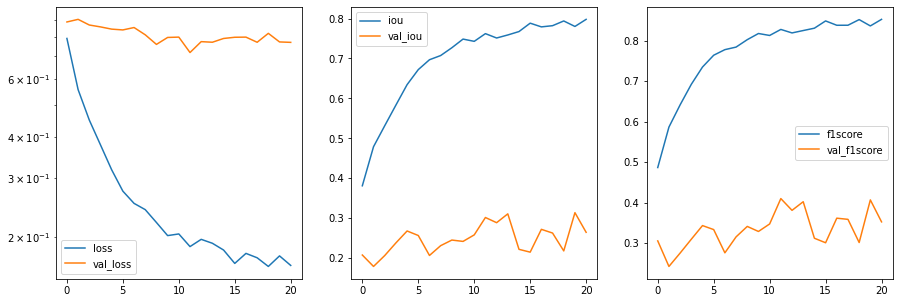

509/509 [==============================] - 1101s 2s/step - loss: 0.1636 - iou_score: 0.7980 - f1-score: 0.8530 - val_loss: 0.7714 - val_iou_score: 0.2647 - val_f1-score: 0.3527
Epoch 22/70
 84/509 [===>..........................] - ETA: 12:45 - loss: 0.1091 - iou_score: 0.8621 - f1-score: 0.9022

In [ ]:
history = m.fit(
            x = training, 
            steps_per_epoch=int(TRAIN_SIZE / BATCH_SIZE), 
            epochs=EPOCHS, 
            callbacks=callbacks, 
            validation_data=validation, 
            validation_steps=int(VAL_SIZE/BATCH_SIZE))

np.save(join(model_dir,'historia_modelo.npy'),history.history)

##Verificar entrenamiento y determinar exactitud en los datos de evaluación

In [ ]:
hist_data = np.load(join(model_dir,'historia_modelo.npy'), allow_pickle=True).item()

In [ ]:
# Plot training & validation iou_score values
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(hist_data['iou_score'])
plt.plot(hist_data['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(np.log(hist_data['loss']))
plt.plot(np.log(hist_data['val_loss']))
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
#Evaluar resultados en la partición de evaluación
evalMetrics = m.evaluate(x=evaluation, steps = EVAL_SIZE, verbose = 1)

##Continuar entrenamiento en modelo salvado
Esto se recomienda en caso de que se necesita entrenar por más epocas el modelo. Se debe cargar los componentes de funciones delo modelo

In [22]:
def load_model_weights(periodo, model_dir, modelname, modeltype, costloss, pretrained=True, rgb=True):
  
  if costloss == 'diceloss':
    target_loss = sm.losses.DiceLoss()
  elif costloss == 'focalloss':
    target_loss = sm.losses.BinaryFocalLoss()
  elif costloss == 'dicefocalloss':
    loss1 = sm.losses.DiceLoss()
    loss2 = sm.losses.BinaryFocalLoss()
    target_loss = loss1 + (1 * loss2)
  elif costloss == 'focaltverskyloss':
    target_loss = FocalTverskyLoss()
  elif costloss == 'BCEloss':
    target_loss = sm.losses.BinaryCELoss()
  elif costloss == 'jaccardloss':
    target_loss = sm.losses.JaccardLoss()

  if modelname == 'unet-sm':
    if pretrained and not rgb:
      print(f'El modelo {modeltype} usando el metodo {modelname} va ser cargado y fue entrenado para el periodo {periodo} usando bandas RGB-NIR e iniciado con los pesos de imagenet y función de perdida {costloss}')
      base_model = sm.Unet(backbone_name=modeltype, encoder_weights='imagenet', classes=1, activation='sigmoid')
      inp = layers.Input(shape=(None, None, 8))
      l1 = layers.Conv2D(3, (1, 1))(inp) # map N channels data to 3 channels
      out = base_model(l1)
      model = models.Model(inp, out, name=base_model.name)
    elif pretrained and rgb:
      print(f'El modelo {modeltype} usando el metodo {modelname} va ser cargado y fue entrenado para el periodo {periodo} usando bandas RGB e iniciado con los pesos de imagenet y función de perdida {costloss}')
      model = sm.Unet(backbone_name=modeltype, encoder_weights='imagenet', classes=1, activation='sigmoid')
    elif rgb:
      print(f'El modelo {modeltype} usando el metodo {modelname} va ser cargado y fue entrenado para el periodo {periodo} desde su inicio (scratch) usando bandas RGB y función de perdida {costloss}')
      model = sm.Unet(modeltype, classes=1, activation='sigmoid', encoder_weights=None)
    else:
      print(f'El modelo {modeltype} usando el metodo {modelname} va ser cargado y fue entrenado para el periodo {periodo} desde su inicio (scratch) usando bandas RGB-NIR y función de perdida {costloss}')
      model = sm.Unet(modeltype, input_shape=(None, None, 8), classes=1, activation='sigmoid', encoder_weights=None)
  elif modelname == 'fpn-sm':
    if pretrained and not rgb:
      print(f'El modelo {modeltype} usando el metodo {modelname} va ser cargado y fue para el periodo {periodo} entrenado usando bandas RGB-NIR e iniciado con los pesos de imagenet y función de perdida {costloss}')
      base_model = sm.FPN(backbone_name=modeltype, encoder_weights='imagenet', classes=1, activation='sigmoid')
      inp = layers.Input(shape=(None, None, 8))
      l1 = layers.Conv2D(3, (1, 1))(inp) # map N channels data to 3 channels
      out = base_model(l1)
      model = models.Model(inp, out, name=base_model.name)
    elif pretrained and rgb:
      print(f'El modelo {modeltype} usando el metodo {modelname} va ser cargado y fue entrenado para el periodo {periodo} usando bandas RGB e iniciado con los pesos de imagenet y función de perdida {costloss}')
      model = sm.FPN(backbone_name=modeltype, encoder_weights='imagenet', classes=1, activation='sigmoid')
    elif rgb:
      print(f'El modelo {modeltype} usando el metodo {modelname} va ser cargado y fue entrenado para el periodo {periodo} desde su inicio (scratch) usando bandas RGB y función de perdida {costloss}')
      model = sm.FPN(modeltype, classes=1, activation='sigmoid', encoder_weights=None)
    else:
      print(f'El modelo {modeltype} usando el metodo {modelname} va ser cargado y fue entrenado para el periodo {periodo} desde su inicio (scratch) usando bandas RGB-NIR y función de perdida {costloss}')
      model = sm.FPN(modeltype, input_shape=(None, None, 8), classes=1, activation='sigmoid', encoder_weights=None)
  elif modelname == 'unet-manual':
      model = unet_model()
      if rgb:
        print(f'El modelo {modeltype} usando el metodo {modelname} va ser cargado y fue entrenado para el periodo {periodo} desde su inicio (scratch) usando bandas RGB y función de perdida {costloss}')
      else:
        print(f'El modelo {modeltype} usando el metodo {modelname} va ser cargado y fue entrenado para el periodo {periodo} desde su inicio (scratch) usando bandas RGB-NIR y función de perdida {costloss}')

  optim = tf.keras.optimizers.Adam(1e-4)
  
  total_loss = target_loss

  metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

  model.load_weights(model_dir + '/model-ep045.hdf5')

  # compile keras model with defined optimozer, loss and metrics
  model.compile(optim, total_loss, metrics)

  return model

In [23]:
modelname = 'unet-sm'
backbone = 'efficientnetb3'
#backbone = 'resnet34' //backbone para modelo unet-sm
costfunction = 'dicefocalloss' #'focaltverskyloss'
pretrained = True
rgb = False
earlystop = False

periodo = 'T1-T2-T3'
EPOCHS = 80

if pretrained:
  weights = 'pretrained'
else:
  weights = 'scratch'

if rgb:
  inputdata = 'RGB'
else:
  inputdata = '4RGBNIR'

if earlystop:
  es = 'withES'
else:
  es = 'withoutES'

model_dir = join('/content/gdrive/My Drive',PROYECTO,'modelos',f'{modelname}_{backbone}_{periodo}_epochs{EPOCHS}_{costfunction}_{weights}_{inputdata}_{es}')

#bring in the architecture and best weights from Drive
m = load_model_weights(periodo, model_dir, modelname, backbone, costfunction, pretrained, rgb)

El modelo efficientnetb3 usando el metodo unet-sm va ser cargado y fue entrenado para el periodo T1-T2-T3 usando bandas RGB-NIR e iniciado con los pesos de imagenet y función de perdida dicefocalloss
44113920/44107200 [==============================] - 1s 0us/step


In [ ]:
#lets see where were at
evalMetrics = m.evaluate(x=evaluation, steps = EVAL_SIZE, verbose = 1)

800/800 [==============================] - 276s 345ms/step - loss: 0.2416 - iou_score: 0.7105 - f1-score: 0.7815


In [ ]:
EPOCHS = 80

model_dir = join('/content/gdrive/My Drive',PROYECTO,'modelos',f'{modelname}_{backbone}_{periodo}_epochs{EPOCHS}_{costfunction}_{weights}_{inputdata}_{es}')

log_dir = model_dir + '/logs'

os.makedirs(model_dir, exist_ok=True)
os.makedirs(log_dir, exist_ok=True)

#set the monitored value (val_mean_io_u) to current evaluation output
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    join(model_dir, 'best_weights.hdf5'),
    monitor='val_iou_score',
    verbose=1,
    save_best_only=True,
    mode='max'
    )

tensorboard = tf.keras.callbacks.TensorBoard(log_dir= log_dir)

checkpoint.best = evalMetrics[1]
print(checkpoint.__dict__)
print(checkpoint.best)

{'validation_data': None, 'model': None, '_chief_worker_only': False, 'monitor': 'val_iou_score', 'verbose': 1, 'filepath': '/content/gdrive/My Drive/Mineria2_Planet/modelos/unet-sm_efficientnetb3_T1-T2-T3_epochs80_dicefocalloss_pretrained_4RGBNIR_withoutES/best_weights.hdf5', 'save_best_only': True, 'save_weights_only': False, 'save_freq': 'epoch', 'epochs_since_last_save': 0, '_batches_seen_since_last_saving': 0, 'load_weights_on_restart': False, 'period': 1, 'monitor_op': <ufunc 'greater'>, 'best': 0.7252345085144043}
0.7252345085144043


In [ ]:
#Now keep training!
history = m.fit(
            x = training, 
            steps_per_epoch=int(TRAIN_SIZE / BATCH_SIZE), 
            epochs=EPOCHS, 
            callbacks=callbacks, 
            validation_data=validation, 
            validation_steps=int(VAL_SIZE/BATCH_SIZE))

np.save(join(model_dir,'historia_modelo.npy'),history.history)

In [ ]:
hist_data = np.load(join(model_dir,'historia_modelo.npy'), allow_pickle=True).item()

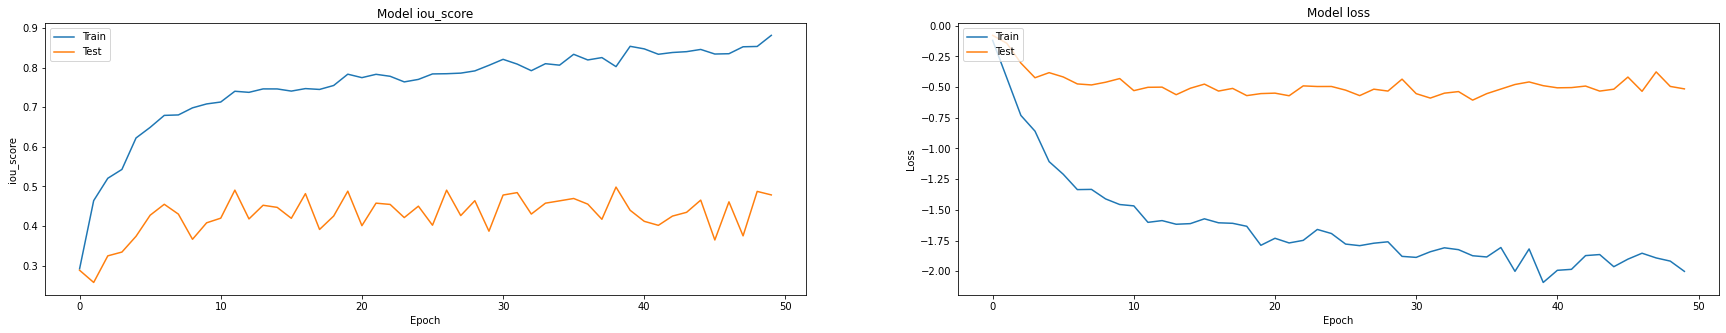

In [ ]:
# Plot training & validation iou_score values
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(hist_data['iou_score'])
plt.plot(hist_data['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(np.log(hist_data['loss']))
plt.plot(np.log(hist_data['val_loss']))
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
#Evaluar resultados en la partición de evaluación
evalMetrics = m.evaluate(x=evaluation, steps = EVAL_SIZE, verbose = 1)

Evaluar Prediccion

50/50 [==============================] - 24s 486ms/step


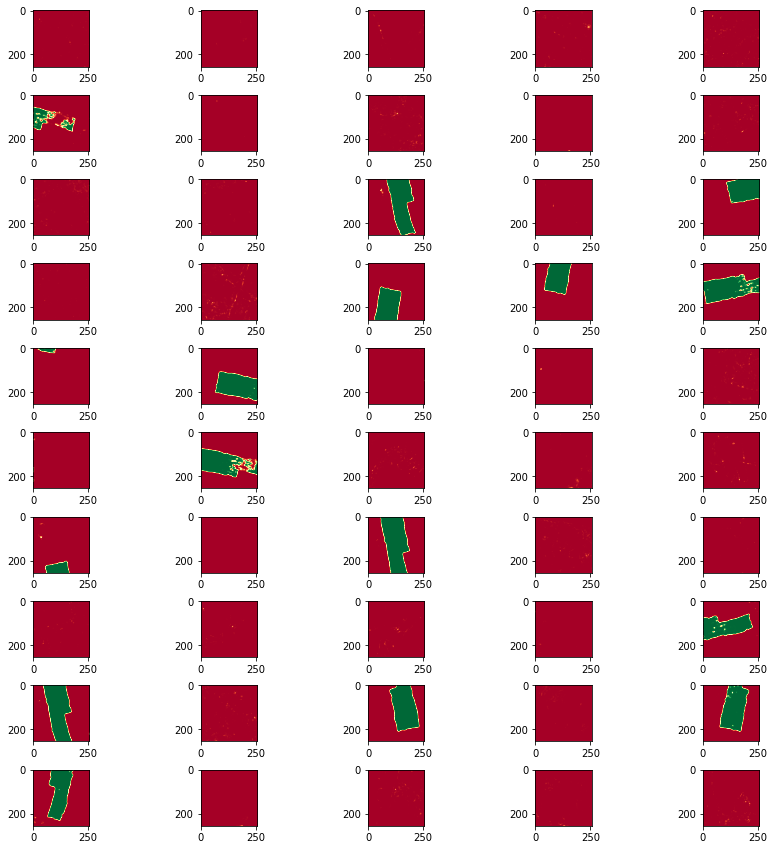

In [24]:
#Inspect the prediction outputs
predictions = m.predict(evaluation, steps=50, verbose=1)
# for prediction in predictions:
#   print(predictions.shape)
fig, axs = plt.subplots(10,5, figsize=(15, 15), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)

axs = axs.ravel()

for i in range(50):
    axs[i].imshow(predictions[i,:,:,0],cmap='RdYlGn')

In [25]:
def doExport(image, out_image_base, kernel_buffer, region, resolucion):
  """
  Run an image export task on which to run predictions.  Block until complete.
  Parameters:
    image (ee.Image): image to be exported for prediction
    path (str): google cloud directory path for export
    out_image_base (str): base filename of exported image
    kernel_buffer (array<int>): pixels to buffer the prediction patch. half added to each side
    region (ee.Geometry):
  """
  image_export_options = {
      'patchDimensions': KERNEL_SHAPE,
      'kernelSize': kernel_buffer,
      'compressed': True,
      'maxFileSize': 104857600
  }

  # Setup the task.
  task = ee.batch.Export.image.toDrive(
    image=image.select(BANDS),
    description=out_image_base,
    fileNamePrefix=out_image_base,
    folder=PROYECTO,
    scale=resolucion,
    fileFormat='TFRecord',
    maxPixels = 1e13,
    region=region.getInfo()['coordinates'],
    formatOptions=image_export_options,
  )

  task.start()

  # Block until the task completes.
  print('Running image export to Google Drive...')
  import time
  while task.active():
    time.sleep(30)

  # Error condition
  if task.status()['state'] != 'COMPLETED':
    print('Error with image export.')
  else:
    print('Image export completed.')

In [26]:
def doExportg(image, out_image_base, kernel_buffer, region, resolucion):
  """
  Run an image export task on which to run predictions.  Block until complete.
  Parameters:
    image (ee.Image): image to be exported for prediction
    path (str): google cloud directory path for export
    out_image_base (str): base filename of exported image
    kernel_buffer (array<int>): pixels to buffer the prediction patch. half added to each side
    region (ee.Geometry):
  """
  image_export_options = {
      'patchDimensions': KERNEL_SHAPE,
      'kernelSize': kernel_buffer,
      'compressed': True,
      'maxFileSize': 104857600
  }

  # Setup the task.
  task = ee.batch.Export.image.toCloudStorage(
    image=image.select(BANDS),
    description=out_image_base,
    fileNamePrefix=out_image_base,
    bucket=BUCKET,
    scale=resolucion,
    fileFormat='TFRecord',
    maxPixels = 1e13,
    region=region.getInfo()['coordinates'],
    formatOptions=image_export_options,
  )

  task.start()

  # Block until the task completes.
  print('Running image export to Google Drive...')
  import time
  while task.active():
    time.sleep(30)

  # Error condition
  if task.status()['state'] != 'COMPLETED':
    print('Error with image export.')
  else:
    print('Image export completed.')

In [27]:
def doPrediction(OUTPUT_FOLDER, out_image_base, kernel_buffer, region):
  """
  Perform inference on exported imagery, upload to Earth Engine.
  Parameters:
    pred_path (str): Google cloud (or Drive) path storing prediction image files
    out_image_base (str): base filename for GEE asset
    kernel_buffer (Array<int>): length 2 array 
    region (ee.Geometry)):
  """

  print('Looking for TFRecord files...')
  
  # Get a list of all the files in the output bucket.
  files_list  = glob.glob('/content/gdrive/My Drive' + '/' + OUTPUT_FOLDER + '/*')
  # Get only the files generated by the image export.
  exported_files_list = [s for s in files_list if IMAGE_FILE_PREFIX in s]
  print(exported_files_list)

  # Get the list of image files and the JSON mixer file.
  imageFilesList = []
  json_file = None
  for f in exported_files_list:
    if f.endswith('.tfrecord.gz'):
      imageFilesList.append(f)
    elif f.endswith('.json'):
      json_file = f

  import json
  with open(json_file) as file:
    mixer = json.load(file)
  print(mixer)
  patches = mixer['totalPatches']
  print(patches)
  # Get set up for prediction.
  x_buffer = int(kernel_buffer[0] / 2)
  y_buffer = int(kernel_buffer[1] / 2)

  buffered_shape = [
      KERNEL_SHAPE[0] + kernel_buffer[0],
      KERNEL_SHAPE[1] + kernel_buffer[1]]

  imageColumns = [
    tf.io.FixedLenFeature(shape=buffered_shape, dtype=tf.float32) 
      for k in BANDS
  ]

  imageFeaturesDict = dict(zip(BANDS, imageColumns))

  def parse_image(example_proto):
    return tf.io.parse_single_example(example_proto, imageFeaturesDict)

  def toTupleImage(dic):
    inputsList = [dic.get(key) for key in BANDS]
    stacked = tf.stack(inputsList, axis=0)
    stacked = tf.transpose(stacked, [1, 2, 0])
    stacked = normalize(stacked, [0, 1])
    return stacked
  
  #Create dir prediction
  import os
  os.chdir('/content/gdrive/My Drive/'+OUTPUT_FOLDER)
  os.getcwd()
  if os.path.isdir('prediction'):
    print('existe directorio prediction')
  else:
    os.mkdir('prediction')

  # Create a dataset(s) from the TFRecord file(s) in Cloud Storage.
  i = 0
  patches = 0
  written_files = []
  while i < len(imageFilesList):
    imageDataset = tf.data.TFRecordDataset(imageFilesList[i:i+100], compression_type='GZIP')
    imageDataset = imageDataset.map(parse_image, num_parallel_calls=5)
    imageDataset = imageDataset.map(toTupleImage).batch(1)
    
    # Perform inference.
    print('Running predictions...')
    predictions = m.predict(imageDataset, steps=None, verbose=1)
    # print(predictions[0])

    out_image_file = join('/content/gdrive/My Drive', OUTPUT_FOLDER,
                          'prediction',
                          '{}{}.TFRecord'.format(out_image_base, i))
    
    print('Writing predictions to ' + out_image_file + '...')
    writer = tf.io.TFRecordWriter(out_image_file)  
    for predictionPatch in predictions:
      print('Writing patch ' + str(patches) + '...')
      predictionPatch = predictionPatch[
          x_buffer:x_buffer+KERNEL_SIZE, y_buffer:y_buffer+KERNEL_SIZE]

      # Create an example.
      example = tf.train.Example(
        features=tf.train.Features(
          feature={
            'probability': tf.train.Feature(
                float_list=tf.train.FloatList(
                    value=predictionPatch.flatten()))
          }
        )
      )
      # Write the example.
      writer.write(example.SerializeToString())
      patches += 1

    writer.close()
    i += 100
    written_files.append(out_image_file)

In [28]:
def doPredictiong(OUTPUT_BUCKET, out_image_base, kernel_buffer, region):
  """
  Perform inference on exported imagery, upload to Earth Engine.
  Parameters:
    pred_path (str): Google cloud (or Drive) path storing prediction image files
    out_image_base (str): base filename for GEE asset
    kernel_buffer (Array<int>): length 2 array 
    region (ee.Geometry)):
  """

  print('Looking for TFRecord files...')
  
  # Get a list of all the files in the output bucket.
  files_list  = !gsutil ls 'gs://'{OUTPUT_BUCKET}
  # Get only the files generated by the image export.
  exported_files_list = [s for s in files_list if IMAGE_FILE_PREFIX in s]
  print(exported_files_list)

  # Get the list of image files and the JSON mixer file.
  imageFilesList = []
  json_file = None
  for f in exported_files_list:
    if f.endswith('.tfrecord.gz'):
      imageFilesList.append(f)
    elif f.endswith('.json'):
      json_file = f

  imageFilesList.sort()
  print(imageFilesList)
  print(json_file)
  
  import json
  # with open(json_file) as file:
  #   mixer = json.load(file)
  # Load the contents of the mixer file to a JSON object.
  json_text = !gsutil cat {json_file}
  # Get a single string w/ newlines from the IPython.utils.text.SList
  mixer = json.loads(json_text.nlstr)
  print(mixer)

  print(mixer)
  patches = mixer['totalPatches']
  print(patches)
  # Get set up for prediction.
  x_buffer = int(kernel_buffer[0] / 2)
  y_buffer = int(kernel_buffer[1] / 2)

  buffered_shape = [
      KERNEL_SHAPE[0] + kernel_buffer[0],
      KERNEL_SHAPE[1] + kernel_buffer[1]]

  imageColumns = [
    tf.io.FixedLenFeature(shape=buffered_shape, dtype=tf.float32) 
      for k in BANDS
  ]

  imageFeaturesDict = dict(zip(BANDS, imageColumns))

  def parse_image(example_proto):
    return tf.io.parse_single_example(example_proto, imageFeaturesDict)

  def toTupleImage(dic):
    inputsList = [dic.get(key) for key in BANDS]
    stacked = tf.stack(inputsList, axis=0)
    stacked = tf.transpose(stacked, [1, 2, 0])
    stacked = normalize(stacked, [0, 1])
    return stacked
  
  #Create dir prediction
  # import os
  # os.chdir('/content/gdrive/My Drive/'+OUTPUT_BUCKET)
  # os.getcwd()
  # if os.path.isdir('prediction'):
  #   print('existe directorio prediction')
  # else:
  #   os.mkdir('prediction')

  # Create a dataset(s) from the TFRecord file(s) in Cloud Storage.
  i = 0
  patches = 0
  written_files = []
  while i < len(imageFilesList):
    imageDataset = tf.data.TFRecordDataset(imageFilesList[i:i+100], compression_type='GZIP')
    imageDataset = imageDataset.map(parse_image, num_parallel_calls=5)
    imageDataset = imageDataset.map(toTupleImage).batch(1)
    
    # Perform inference.
    print('Running predictions...')
    predictions = m.predict(imageDataset, steps=None, verbose=1)
    # print(predictions[0])

    # out_image_file = join('/content/gdrive/My Drive', OUTPUT_BUCKET,
    #                       'prediction',
    #                       '{}{}.TFRecord'.format(out_image_base, i))
    out_image_file = join('gs://', OUTPUT_BUCKET,
                          '{}{}.TFRecord'.format(out_image_base, i))
    
    print('Writing predictions to ' + out_image_file + '...')
    writer = tf.io.TFRecordWriter(out_image_file)  
    for predictionPatch in predictions:
      print('Writing patch ' + str(patches) + '...')
      predictionPatch = predictionPatch[
          x_buffer:x_buffer+KERNEL_SIZE, y_buffer:y_buffer+KERNEL_SIZE]

      # Create an example.
      example = tf.train.Example(
        features=tf.train.Features(
          feature={
            'probability': tf.train.Feature(
                float_list=tf.train.FloatList(
                    value=predictionPatch.flatten()))
          }
        )
      )
      # Write the example.
      writer.write(example.SerializeToString())
      patches += 1

    writer.close()
    i += 100
    written_files.append(out_image_file)

In [101]:
###subzonas###
aoi_eval = ee.FeatureCollection('users/mazarazaa/AreaF_Planet')
#imagen = ee.Image('users/mazarazaa/stacked_mosaic_2017_2019')
#imagen = ee.Image('users/mazarazaa/2017_12_14_planet') Generada
#imagen = ee.Image('users/mazarazaa/stacked_mosaic_201710_201712')
#imagen = ee.Image('users/mazarazaa/stacked_mosaic_201712_201803')
#imagen = ee.Image('users/mazarazaa/stacked_mosaic_201803_201806') 
#imagen = ee.Image('users/mazarazaa/stacked_mosaic_201806_201812')
#imagen = ee.Image('users/mazarazaa/stacked_mosaic_201812_201902')
#imagen = ee.Image('users/mazarazaa/stacked_mosaic_201902_201908')
imagen = ee.Image('users/mazarazaa/stacked_mosaic_201908_201911').select('b1', 'b2', 'b3', 'b4','b5', 'b6', 'b7', 'b8').rename('B', 'G', 'R', 'NIR','B2', 'G2', 'R2', 'NIR2').unmask(0)
print(aoi_eval.getInfo())
nc_kernel_buffer = [256, 256]
aoi_fil = aoi_eval.filter(ee.Filter.eq('type','Feature'))
resolucion = imagen.projection().nominalScale().getInfo()
for i in range(aoi_eval.size().getInfo()):
 a = aoi_eval.filter(ee.Filter.eq('ID_new', i))
 img_eval = imagen.clip(a).float()
 imagen_name = 'eval_image_201908_201911_3t80u'+str(i)
 nc_region = a.geometry()
 print(img_eval.getInfo())
 doExportg(img_eval, imagen_name, nc_kernel_buffer, nc_region, resolucion)

{'type': 'FeatureCollection', 'columns': {'ID_new': 'Integer', 'system:index': 'String'}, 'version': 1612043956626468, 'id': 'users/mazarazaa/AreaF_Planet', 'properties': {'system:asset_size': 8683}, 'features': [{'type': 'Feature', 'geometry': {'type': 'Polygon', 'coordinates': [[[-72.68656489314259, 11.014158914691691], [-72.61138643634443, 11.013341418856358], [-72.61031354077299, 11.02033406083657], [-72.55563932363509, 11.053736496896756], [-72.51067027797724, 11.109346279269904], [-72.51067027797724, 11.173853411915568], [-72.68645159149222, 11.174527088788764], [-72.68656489314259, 11.014158914691691]]]}, 'id': '00000000000000000000', 'properties': {'ID_new': 0}}]}
{'type': 'Image', 'bands': [{'id': 'B', 'data_type': {'type': 'PixelType', 'precision': 'float'}, 'dimensions': [6323, 5844], 'crs': 'EPSG:32618', 'crs_transform': [3, 0, 752847.1873209288, 0, -3, 1236087.4990433345]}, {'id': 'G', 'data_type': {'type': 'PixelType', 'precision': 'float'}, 'dimensions': [6323, 5844], 'c

In [ ]:
# ###subzonas###
# #aoi_eval = ee.FeatureCollection('users/mazarazaa/aoi2_eval_planet')
# aoi_eval = ee.FeatureCollection('users/mazarazaa/aois_imgplanet')
# imagen = ee.Image('users/mazarazaa/2018_03_10_planet').select('b1', 'b2', 'b3', 'b4').rename('B', 'G', 'R', 'NIR').unmask(0)
# print(aoi_eval.getInfo())
# nc_kernel_buffer = [64, 64]
# resolucion = imagen.projection().nominalScale().getInfo()
# for i in range(aoi_eval.size().getInfo()):
#   a = aoi_eval.filter(ee.Filter.eq('ID_new', i))
#   nc_region = a.geometry()
#   IMAGE_FILE_PREFIX = 'eval_image_Pl2017_64'+str(i)
#   doPrediction(OUTPUT_FOLDER = PROYECTO,
#              out_image_base = 'eval2_'+str(i),
#              kernel_buffer = nc_kernel_buffer,
#              region = nc_region)

In [102]:
OUTPUT_BUCKET = 'mineriapr'
#aoi_eval = ee.FeatureCollection('users/mazarazaa/Area_eval_2017_2019')
aoi_eval = ee.FeatureCollection('users/mazarazaa/AreaF_Planet')
imagen = ee.Image('users/mazarazaa/stacked_mosaic_201908_201911').select('b1', 'b2', 'b3', 'b4','b5', 'b6', 'b7', 'b8').rename('B', 'G', 'R', 'NIR','B2', 'G2', 'R2', 'NIR2').unmask(0) 
print(aoi_eval.getInfo())
nc_kernel_buffer = [256, 256]
resolucion = imagen.projection().nominalScale().getInfo()
for i in range(aoi_eval.size().getInfo()):
  a = aoi_eval.filter(ee.Filter.eq('ID_new', i))
  nc_region = a.geometry()
  IMAGE_FILE_PREFIX = 'eval_image_201908_201911_3t80u'+str(i)
  doPredictiong(OUTPUT_BUCKET = 'mineriapr',
             out_image_base = '201908_201911_cm3t80u'+str(i),
             kernel_buffer = nc_kernel_buffer,
             region = nc_region)

{'type': 'FeatureCollection', 'columns': {'ID_new': 'Integer', 'system:index': 'String'}, 'version': 1612043956626468, 'id': 'users/mazarazaa/AreaF_Planet', 'properties': {'system:asset_size': 8683}, 'features': [{'type': 'Feature', 'geometry': {'type': 'Polygon', 'coordinates': [[[-72.68656489314259, 11.014158914691691], [-72.61138643634443, 11.013341418856358], [-72.61031354077299, 11.02033406083657], [-72.55563932363509, 11.053736496896756], [-72.51067027797724, 11.109346279269904], [-72.51067027797724, 11.173853411915568], [-72.68645159149222, 11.174527088788764], [-72.68656489314259, 11.014158914691691]]]}, 'id': '00000000000000000000', 'properties': {'ID_new': 0}}]}
Looking for TFRecord files...
['gs://mineriapr/eval_image_201908_201911_3t80u000000.tfrecord.gz', 'gs://mineriapr/eval_image_201908_201911_3t80u000001.tfrecord.gz', 'gs://mineriapr/eval_image_201908_201911_3t80u000002.tfrecord.gz', 'gs://mineriapr/eval_image_201908_201911_3t80u000003.tfrecord.gz', 'gs://mineriapr/eval

In [105]:
aoi_eval = ee.FeatureCollection('users/mazarazaa/AreaF_Planet')
#for i in range(aoi_eval.size().getInfo()):
for i in range(aoi_eval.size().getInfo()):
  out_image_base = '201908_201911_cm3t80u'+str(i) +'0.TFRecord'
  OUTPUT_IMAGE_FILE = 'gs://mineriapr/' + out_image_base
  !gsutil ls -l {OUTPUT_IMAGE_FILE}
  name_img = 'pr_image_201908_2019113t80u'+str(i)

  OUTPUT_ASSET_ID = 'users/mazarazaa/' + name_img
  print('Uploading to ' + OUTPUT_ASSET_ID)
  print('Writing to file ' + OUTPUT_IMAGE_FILE)
  name_json = 'eval_image_201908_201911_3t80u'+str(i)+'mixer.json'
  json_file = 'gs://mineriapr/'+name_json
  print(json_file)

  !earthengine upload image --asset_id={OUTPUT_ASSET_ID} --pyramiding_policy=mode {OUTPUT_IMAGE_FILE} {json_file}

 150760975  2021-04-20T18:24:52Z  gs://mineriapr/201908_201911_cm3t80u00.TFRecord
TOTAL: 1 objects, 150760975 bytes (143.78 MiB)
Uploading to users/mazarazaa/pr_image_201908_2019113t80u0
Writing to file gs://mineriapr/201908_201911_cm3t80u00.TFRecord
gs://mineriapr/eval_image_201908_201911_3t80u0mixer.json
Instructions for updating:
non-resource variables are not supported in the long term
Started upload task with ID: IMXPMH6AFVPIKBYUK3OR4KYM


In [112]:
ee.batch.Task.list()

[<Task IMXPMH6AFVPIKBYUK3OR4KYM INGEST_IMAGE: Ingest image: "projects/earthengine-legacy/assets/users/mazarazaa/pr_image_201908_2019113t80u0" (RUNNING)>,
 <Task DSVF4FVXCW3OF3TBJVG7VVWW INGEST_IMAGE: Ingest image: "projects/earthengine-legacy/assets/users/mazarazaa/pr_image_201908_2019113t80u0" (FAILED)>,
 <Task RI2TZDAWI5472BGEKV6WOR5Q EXPORT_IMAGE: eval_image_201908_201911_3t80u0 (COMPLETED)>,
 <Task 6AH3RCDHCMMBYIDEB5KVIKKS INGEST_IMAGE: Ingest image: "projects/earthengine-legacy/assets/users/mazarazaa/pr_image_201902_2019083t80u0" (RUNNING)>,
 <Task 4MOVT2F6OXCFYMPC6SDTQNY5 INGEST_IMAGE: Ingest image: "projects/earthengine-legacy/assets/users/mazarazaa/pr_image_201902_2019083t80u0" (FAILED)>,
 <Task W2GXD2U4H32OGY3HI77NY3HQ INGEST_IMAGE: Ingest image: "projects/earthengine-legacy/assets/users/mazarazaa/pr_image_201902_2019083t80u0" (FAILED)>,
 <Task 2RNC2SXLCZRAXFPKDTRILJZ4 EXPORT_IMAGE: eval_image_201902_201908_3t80u0 (COMPLETED)>,
 <Task EM3IUPGOOHGIZFXPI35FI5MN INGEST_IMAGE: Ing

In [ ]:
predictions_image = ee.Image('users/mazarazaa/eval_pl_c3')

prediction_vis = {
  'bands': 'probability',
  'min': 0,
  'max': 1,
}
#probability_vis = {'bands': ['Mineria', 'NoMineria'], 'max': 0.5}

imagen_2017 = ee.Image('users/mazarazaa/2017_12_14_planet')
prediction_map_id = predictions_image.getMapId(prediction_vis)
#probability_map_id = predictions_image.getMapId(probability_vis)
mapid = imagen_2017.getMapId({'bands': ['b1', 'b2', 'b3'], 'min': 50, 'max': 1500})

map = folium.Map(location=[6.32, -75.72], zoom_start=15)
folium.TileLayer(
  tiles=prediction_map_id['tile_fetcher'].url_format,
  attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
  overlay=True,
  name='prediction',
).add_to(map)
# folium.TileLayer(
#   tiles=probability_map_id['tile_fetcher'].url_format,
#   attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
#   overlay=True,
#   name='probability',
# ).add_to(map)
folium.TileLayer(
  tiles=mapid['tile_fetcher'].url_format,
  attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
  overlay=True,
  name='image',
).add_to(map)
map.add_child(folium.LayerControl())
map

Nuevo Modelo

In [ ]:
EPOCHS = 100

model_dir = join('/content/gdrive/My Drive',PROYECTO,'modelos',f'{modelname}_{backbone}_{periodo}_epochs{EPOCHS}_{costfunction}_{weights}_{inputdata}_{es}')

log_dir = model_dir + '/logs'

os.makedirs(model_dir, exist_ok=True)
os.makedirs(log_dir, exist_ok=True)

#set the monitored value (val_mean_io_u) to current evaluation output
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    join(model_dir, 'best_weights.hdf5'),
    monitor='val_iou_score',
    verbose=1,
    save_best_only=True,
    mode='max'
    )

tensorboard = tf.keras.callbacks.TensorBoard(log_dir= log_dir)

checkpoint.best = evalMetrics[1]
print(checkpoint.__dict__)
print(checkpoint.best)

In [ ]:
#Now keep training!
history = m.fit(
            x = training, 
            steps_per_epoch=int(TRAIN_SIZE / BATCH_SIZE), 
            epochs=EPOCHS, 
            callbacks=callbacks, 
            validation_data=validation, 
            validation_steps=int(VAL_SIZE/BATCH_SIZE))

np.save(join(model_dir,'historia_modelo.npy'),history.history)